In [1]:
%matplotlib inline

# Example: Baseball Batting Average

Original example from Pyro:
https://github.com/pyro-ppl/pyro/blob/dev/examples/baseball.py

Example has been adapted from [1]. It demonstrates how to do Bayesian inference using
various MCMC kernels in Pyro (HMC, NUTS, SA), and use of some common inference utilities.

As in the Stan tutorial, this uses the small baseball dataset of Efron and Morris [2]
to estimate players' batting average which is the fraction of times a player got a
base hit out of the number of times they went up at bat.

The dataset separates the initial 45 at-bats statistics from the remaining season.
We use the hits data from the initial 45 at-bats to estimate the batting average
for each player. We then use the remaining season's data to validate the predictions
from our models.

Three models are evaluated:

    - Complete pooling model: The success probability of scoring a hit is shared
      amongst all players.
    - No pooling model: Each individual player's success probability is distinct and
      there is no data sharing amongst players.
    - Partial pooling model: A hierarchical model with partial data sharing.

We recommend Radford Neal's tutorial on HMC ([3]) to users who would like to get a
more comprehensive understanding of HMC and its variants, and to [4] for details on
the No U-Turn Sampler, which provides an efficient and automated way (i.e. limited
hyper-parameters) of running HMC on different problems.

Note that the Sample Adaptive (SA) kernel, which is implemented based on [5],
requires large `num_warmup` and `num_samples` (e.g. 15,000 and 300,000). So
it is better to disable progress bar to avoid dispatching overhead.

**References:**

1. Carpenter B. (2016), ["Hierarchical Partial Pooling for Repeated Binary Trials"](https://mc-stan.org/users/documentation/case-studies/pool-binary-trials.html)
2. Efron B., Morris C. (1975), "Data analysis using Stein's estimator and its
   generalizations", J. Amer. Statist. Assoc., 70, 311-319.
3. Neal, R. (2012), "MCMC using Hamiltonian Dynamics",
   (https://arxiv.org/pdf/1206.1901.pdf)
4. Hoffman, M. D. and Gelman, A. (2014), "The No-U-turn sampler: Adaptively setting
   path lengths in Hamiltonian Monte Carlo", (https://arxiv.org/abs/1111.4246)
5. Michael Zhu (2019), "Sample Adaptive MCMC",
   (https://papers.nips.cc/paper/9107-sample-adaptive-mcmc)


In [3]:
import argparse
import os

import jax
import jax.numpy as jnp
import jax.random as random
from jax.scipy.special import logsumexp

import numpyro
import numpyro as npr
import numpyro.distributions as dist
from numpyro.examples.datasets import BASEBALL, load_dataset
from numpyro.infer import HMC, MCMC, NUTS, SA, Predictive, log_likelihood
print(numpyro.__version__)

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('dark_background')

0.6.0


In [4]:
assert numpyro.__version__.startswith('0.6.0')
num_samples = 5000
num_warmup  = 1500
algo = 'NUTS'  # 'HMC', 'NUTS', 'SA'
num_chains = 1
numpyro.set_host_device_count(num_chains)

## Data
- traint: at_bats, hits
- test: at_bats, hits
- The dataset separates the initial 45 at-bats statistics from the remaining season. 
- We use the hits data from the initial 45 at-bats to **estimate the batting average for each player**.
- We then use the remaining season's data to validate the predictions from our models.

In [5]:
    _, fetch_train = load_dataset(BASEBALL, split='train', shuffle=False)
    train, player_names = fetch_train()
    _, fetch_test = load_dataset(BASEBALL, split='test', shuffle=False)
    test, _ = fetch_test()
    at_bats, hits = train[:, 0], train[:, 1]
    season_at_bats, season_hits = test[:, 0], test[:, 1]
    print('data:', len(at_bats))

Download complete.
data: 18


## Utility Functions

In [75]:
def run_inference(model, at_bats, hits, rng_key, algo='NUTS'):
    if algo == "NUTS":
        kernel = NUTS(model)
    elif algo == "HMC":
        kernel = HMC(model)
    elif algo == "SA":
        kernel = SA(model)
    #
    mcmc = MCMC(kernel, num_warmup, num_samples, num_chains=num_chains, progress_bar=True)
    mcmc.run(rng_key, at_bats, hits)
    mcmc.print_summary()
    return mcmc.get_samples()
#

def predict(model, at_bats, hits, z, rng_key, player_names, train=True):
    header = model.__name__ + (' - TRAIN' if train else ' - TEST')
    predictions = Predictive(model, posterior_samples=z)(rng_key, at_bats)['obs']
    print_results('=' * 30 + header + '=' * 30,
                  predictions,
                  player_names,
                  at_bats,
                  hits)
    if not train:
        post_loglik = log_likelihood(model, z, at_bats, hits)['obs']
        # computes expected log predictive density at each data point
        exp_log_density = logsumexp(post_loglik, axis=0) - jnp.log(jnp.shape(post_loglik)[0])
        # reports log predictive density of all test points
        print('\nLog pointwise predictive density: {:.2f}\n'.format(exp_log_density.sum()))
#

def print_results(header, preds, player_names, at_bats, hits):
    columns = ['', 'At-bats', 'ActualHits', 'Pred(p25)', 'Pred(p50)', 'Pred(p75)']
    header_format = '{:>20} {:>10} {:>10} {:>10} {:>10} {:>10}'
    row_format = '{:>20} {:>10.0f} {:>10.0f} {:>10.2f} {:>10.2f} {:>10.2f}'
    quantiles = jnp.quantile(preds, jnp.array([0.25, 0.5, 0.75]), axis=0)
    print('\n', header, '\n')
    print(header_format.format(*columns))
    for i, p in enumerate(player_names):
        print(row_format.format(p, at_bats[i], hits[i], *quantiles[:, i]))
#

## Model: Not_Pooled
- Independent probability of success for each player
- Number of hits in $K$ at bats for each player has a Binomial
    distribution with independent probability of success, $\phi_i$.


In [21]:
def not_pooled(at_bats, hits=None):
    r"""
    Number of hits in $K$ at bats for each player has a Binomial
    distribution with independent probability of success, $\phi_i$.

    :param (jnp.DeviceArray) at_bats: Number of at bats for each player.
    :param (jnp.DeviceArray) hits: Number of hits for the given at bats.
    :return: Number of hits predicted by the model.
    """
    num_players = at_bats.shape[0]
    with numpyro.plate("num_players", num_players):
        phi_prior = dist.Uniform(0, 1)
        phi = numpyro.sample("phi", phi_prior)
        return numpyro.sample("obs", dist.Binomial(at_bats, probs=phi), obs=hits)
#

### Inference

In [24]:
zs = run_inference(not_pooled, at_bats, hits, rng_key=random.PRNGKey(0), algo='NUTS')

sample: 100%|██████████| 4500/4500 [00:05<00:00, 806.66it/s, 7 steps of size 6.71e-01. acc. prob=0.85] 
                mean       std    median      5.0%     95.0%     n_eff     r_hat
    phi[0]      0.40      0.07      0.40      0.29      0.53   7943.76      1.00
    phi[1]      0.38      0.07      0.38      0.27      0.50   7400.61      1.00
    phi[2]      0.36      0.07      0.36      0.25      0.47   7365.36      1.00
    phi[3]      0.34      0.07      0.34      0.22      0.46   7534.42      1.00
    phi[4]      0.32      0.07      0.32      0.21      0.43   8183.98      1.00
    phi[5]      0.32      0.07      0.32      0.21      0.42   7674.42      1.00
    phi[6]      0.30      0.07      0.30      0.19      0.40   7255.39      1.00
    phi[7]      0.28      0.06      0.27      0.17      0.38   6562.46      1.00
    phi[8]      0.25      0.06      0.25      0.15      0.35   6384.14      1.00
    phi[9]      0.25      0.06      0.25      0.15      0.36   7794.58      1.00
   ph

In [31]:
predict(not_pooled, at_bats, hits, zs, random.PRNGKey(0), player_names)


 ==============================not_pooled - TRAIN============================== 

                        At-bats ActualHits  Pred(p25)  Pred(p50)  Pred(p75)
    Roberto Clemente         45         18      15.00      18.00      21.00
      Frank Robinson         45         17      14.00      17.00      20.00
        Frank Howard         45         16      13.00      16.00      19.00
       Jay Johnstone         45         15      12.00      15.00      18.00
           Ken Berry         45         14      11.00      14.00      17.00
         Jim Spencer         45         14      12.00      14.00      17.00
       Don Kessinger         45         13      10.00      13.00      16.00
       Luis Alvarado         45         12      10.00      12.00      15.00
           Ron Santo         45         11       9.00      11.00      14.00
         Ron Swaboda         45         11       9.00      11.00      14.00
     Rico Petrocelli         45         10       8.00      10.00      13.00
     

### Let's produce those prediction results.

In [37]:
zs['phi'].shape  # the mcmc gives posterior samples phi_i for each i-th player. 
i = 0
phi = zs['phi'][:,i]
print(f'{player_names[i]}, {phi[:5]}')

Roberto Clemente, [0.36169615 0.5661766  0.28016263 0.42534524 0.3143292 ]


mean, std: 18.170666 4.605816
quantiles:  15 18 21
quantiles:  0.3333333333333333 0.4 0.4666666666666667


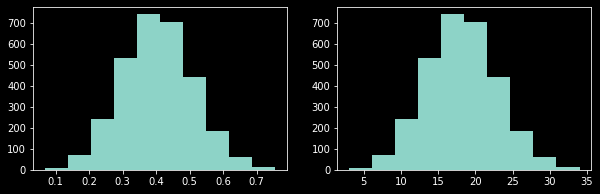

In [69]:
with numpyro.handlers.seed(rng_seed=0):
    pred_hits = numpyro.sample('hits', dist.Binomial(at_bats[i], probs=phi))
#
print('mean, std:', pred_hits.mean(), pred_hits.std())
#
pred_hits = np.sort(pred_hits);
n = len(pred_hits)
print('quantiles: ', pred_hits[int(n*25/100)], pred_hits[int(n*50/100)], pred_hits[int(n*75/100)])
#
pred_hit_rates = pred_hits / at_bats[i]
n = len(pred_hits)
print('quantiles: ', pred_hit_rates[int(n*25/100)], pred_hit_rates[int(n*50/100)], pred_hit_rates[int(n*75/100)])
#
fig, axes = plt.subplots(1,2, figsize=(10,3))
axes[0].hist(pred_hit_rates)
axes[1].hist(pred_hits, bins=10);

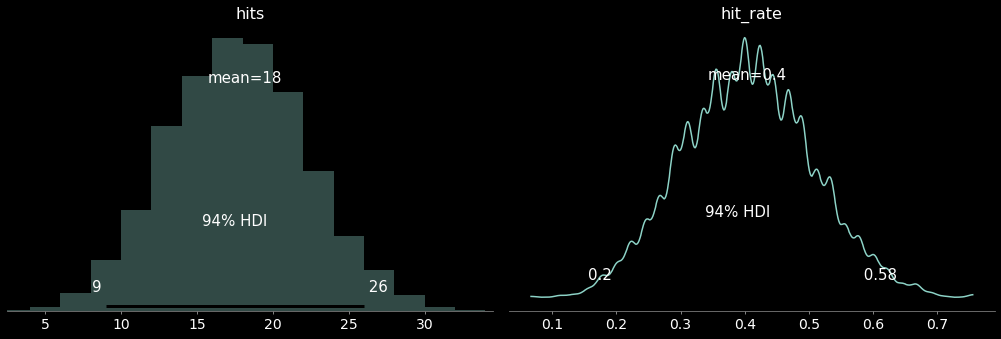

In [67]:
import arviz 
import numpy as np
arviz.plot_posterior({'hits': np.array(pred_hits), 'hit_rate': np.array(pred_hit_rates)});

In [33]:
predict(not_pooled, season_at_bats, season_hits, zs, random.PRNGKey(0), player_names, train=False)


 ==============================not_pooled - TEST============================== 

                        At-bats ActualHits  Pred(p25)  Pred(p50)  Pred(p75)
    Roberto Clemente        412        145     145.00     165.00     188.00
      Frank Robinson        471        144     156.00     179.00     203.00
        Frank Howard        566        160     176.00     204.00     231.00
       Jay Johnstone        320         76      91.00     108.00     125.00
           Ken Berry        463        128     125.00     146.00     169.00
         Jim Spencer        511        140     140.00     162.00     186.00
       Don Kessinger        631        168     157.00     186.00     217.00
       Luis Alvarado        183         41      41.00      50.00      59.00
           Ron Santo        555        148     115.75     139.00     164.00
         Ron Swaboda        245         57      50.00      61.00      73.00
     Rico Petrocelli        583        152     109.00     133.00     159.00
     E

## Modl: Fully Pooled
Number of hits in $K$ at bats for each player has a Binomial
    distribution with a common probability of success, $\phi$.


In [72]:
def fully_pooled(at_bats, hits=None):
    r"""
    Number of hits in $K$ at bats for each player has a Binomial
    distribution with a common probability of success, $\phi$.

    :param (jnp.DeviceArray) at_bats: Number of at bats for each player.
    :param (jnp.DeviceArray) hits: Number of hits for the given at bats.
    :return: Number of hits predicted by the model.
    """
    phi_prior = dist.Uniform(0, 1)
    phi = numpyro.sample("phi", phi_prior)
    num_players = at_bats.shape[0]
    with numpyro.plate("num_players", num_players):
        return numpyro.sample("obs", dist.Binomial(at_bats, probs=phi), obs=hits)


In [79]:
rng_key, rng_key_predict = random.split(random.PRNGKey(i + 1))
zs = run_inference(fully_pooled, at_bats, hits, rng_key)
predict(fully_pooled, at_bats, hits, zs, rng_key_predict, player_names)

sample: 100%|██████████| 4500/4500 [00:06<00:00, 742.55it/s, 3 steps of size 1.02e+00. acc. prob=0.93] 

                mean       std    median      5.0%     95.0%     n_eff     r_hat
       phi      0.27      0.02      0.27      0.24      0.29   1033.68      1.00

Number of divergences: 0

 ==============================fully_pooled - TRAIN============================== 

                        At-bats ActualHits  Pred(p25)  Pred(p50)  Pred(p75)
    Roberto Clemente         45         18      10.00      12.00      14.00
      Frank Robinson         45         17      10.00      12.00      14.00
        Frank Howard         45         16      10.00      12.00      14.00
       Jay Johnstone         45         15      10.00      12.00      14.00
           Ken Berry         45         14      10.00      12.00      14.00
         Jim Spencer         45         14      10.00      12.00      14.00
       Don Kessinger         45         13      10.00      12.00      14.00
       Luis Al

In [80]:
predict(fully_pooled, season_at_bats, season_hits, zs
, rng_key_predict, player_names, train=False)


 ==============================fully_pooled - TEST============================== 

                        At-bats ActualHits  Pred(p25)  Pred(p50)  Pred(p75)
    Roberto Clemente        412        145     103.00     110.00     117.00
      Frank Robinson        471        144     117.00     126.00     134.00
        Frank Howard        566        160     141.00     150.00     160.00
       Jay Johnstone        320         76      79.00      86.00      91.00
           Ken Berry        463        128     115.00     123.00     132.00
         Jim Spencer        511        140     127.00     136.00     145.00
       Don Kessinger        631        168     158.00     168.00     178.00
       Luis Alvarado        183         41      44.00      49.00      53.00
           Ron Santo        555        148     139.00     148.00     157.00
         Ron Swaboda        245         57      60.00      65.00      70.00
     Rico Petrocelli        583        152     145.00     155.00     165.00
    

## Model: Partially Pooled (Hierarchical or Multi-Level)
Number of hits has a Binomial distribution with independent
    probability of success, $\phi_i$. Each $\phi_i$ follows a Beta
    distribution with concentration parameters $c_1$ and $c_2$, where
\begin{align}
    c_1 &= m * \kappa \\
    c_2 &= (1 - m) * \kappa \\
    m &\sim Uniform(0, 1) \quad\mbox{mean of beta}\\
    \kappa &\sim Pareto(1, 1.5)  \quad\mbox{concentration of beta}
\end{align}

In [82]:
def partially_pooled(at_bats, hits=None):
    r"""
    :param (jnp.DeviceArray) at_bats: Number of at bats for each player.
    :param (jnp.DeviceArray) hits: Number of hits for the given at bats.
    :return: Number of hits predicted by the model.
    """
    m = numpyro.sample("m", dist.Uniform(0, 1))
    kappa = numpyro.sample("kappa", dist.Pareto(1, 1.5))
    num_players = at_bats.shape[0]
    with numpyro.plate("num_players", num_players):
        phi_prior = dist.Beta(m * kappa, (1 - m) * kappa)
        phi = numpyro.sample("phi", phi_prior)
        return numpyro.sample("obs", dist.Binomial(at_bats, probs=phi), obs=hits)

In [86]:
rng_key, rng_key_predict = random.split(random.PRNGKey(i + 1))
zs = run_inference(partially_pooled, at_bats, hits, rng_key)

sample: 100%|██████████| 4500/4500 [00:06<00:00, 660.09it/s, 15 steps of size 3.23e-01. acc. prob=0.87] 
                mean       std    median      5.0%     95.0%     n_eff     r_hat
     kappa    118.66    158.28     66.58      6.96    250.14    172.48      1.00
         m      0.27      0.02      0.27      0.24      0.30   2062.98      1.00
    phi[0]      0.32      0.05      0.31      0.24      0.41   1403.08      1.00
    phi[1]      0.31      0.05      0.31      0.23      0.39   1647.85      1.00
    phi[2]      0.30      0.05      0.30      0.22      0.38   2225.13      1.00
    phi[3]      0.29      0.05      0.29      0.22      0.37   3003.99      1.00
    phi[4]      0.29      0.05      0.28      0.22      0.36   3321.05      1.00
    phi[5]      0.29      0.04      0.28      0.21      0.36   3023.91      1.00
    phi[6]      0.28      0.04      0.27      0.20      0.35   3121.51      1.00
    phi[7]      0.27      0.04      0.27      0.19      0.33   4496.26      1.00
    

In [89]:
predict(partially_pooled, at_bats, hits, zs, rng_key_predict, player_names)


 ==============================partially_pooled - TRAIN============================== 

                        At-bats ActualHits  Pred(p25)  Pred(p50)  Pred(p75)
    Roberto Clemente         45         18      12.00      14.00      17.00
      Frank Robinson         45         17      11.00      14.00      17.00
        Frank Howard         45         16      11.00      13.00      16.00
       Jay Johnstone         45         15      11.00      13.00      16.00
           Ken Berry         45         14      10.00      13.00      15.00
         Jim Spencer         45         14      10.00      13.00      15.00
       Don Kessinger         45         13      10.00      12.00      15.00
       Luis Alvarado         45         12      10.00      12.00      14.00
           Ron Santo         45         11       9.00      11.00      14.00
         Ron Swaboda         45         11       9.00      11.00      14.00
     Rico Petrocelli         45         10       9.00      11.00      14.00

In [90]:
predict(partially_pooled, season_at_bats, season_hits, zs, rng_key_predict, player_names, train=False)


 ==============================partially_pooled - TEST============================== 

                        At-bats ActualHits  Pred(p25)  Pred(p50)  Pred(p75)
    Roberto Clemente        412        145     115.00     130.00     147.00
      Frank Robinson        471        144     130.00     145.00     163.00
        Frank Howard        566        160     151.00     169.00     189.00
       Jay Johnstone        320         76      83.00      93.00     105.00
           Ken Berry        463        128     117.00     132.00     147.00
         Jim Spencer        511        140     130.00     145.00     162.00
       Don Kessinger        631        168     154.00     172.00     192.00
       Luis Alvarado        183         41      42.00      49.00      55.00
           Ron Santo        555        148     127.00     143.00     160.00
         Ron Swaboda        245         57      55.00      63.00      72.00
     Rico Petrocelli        583        152     127.00     146.00     163.00


## Model: Partially Pooled with Logit
Number of hits has a Binomial distribution with a logit link function.
    The logits $\alpha$ for each player is normally distributed with the
    mean and scale parameters sharing a common prior.



In [98]:
def partially_pooled_with_logit(at_bats, hits=None):
    r"""
    :param (jnp.DeviceArray) at_bats: Number of at bats for each player.
    :param (jnp.DeviceArray) hits: Number of hits for the given at bats.
    :return: Number of hits predicted by the model.
    """
    loc = numpyro.sample("loc", dist.Normal(-3, 3))
    scale = numpyro.sample("scale", dist.HalfCauchy(1))
    num_players = at_bats.shape[0]
    with numpyro.plate("num_players", num_players):
        alpha = numpyro.sample("alpha", dist.Normal(loc, scale))
        return numpyro.sample("obs", dist.Binomial(at_bats, logits=alpha), obs=hits)
#
model = partially_pooled_with_logit

In [99]:
rng_key, rng_key_predict = random.split(random.PRNGKey(i + 1))
zs = run_inference(model, at_bats, hits, rng_key)

sample: 100%|██████████| 4500/4500 [00:06<00:00, 708.44it/s, 15 steps of size 1.97e-01. acc. prob=0.85] 

                mean       std    median      5.0%     95.0%     n_eff     r_hat
  alpha[0]     -0.87      0.20     -0.91     -1.17     -0.53    412.62      1.00
  alpha[1]     -0.90      0.19     -0.93     -1.20     -0.57    579.58      1.00
  alpha[2]     -0.93      0.19     -0.95     -1.22     -0.63    756.50      1.00
  alpha[3]     -0.95      0.18     -0.97     -1.22     -0.65   1143.07      1.00
  alpha[4]     -0.97      0.18     -0.99     -1.24     -0.65   1294.13      1.00
  alpha[5]     -0.97      0.17     -0.98     -1.24     -0.68   1317.76      1.00
  alpha[6]     -1.00      0.17     -1.00     -1.29     -0.74   1812.18      1.00
  alpha[7]     -1.02      0.17     -1.02     -1.30     -0.73   1852.92      1.00
  alpha[8]     -1.05      0.17     -1.04     -1.35     -0.76   1862.49      1.00
  alpha[9]     -1.05      0.18     -1.04     -1.36     -0.78   1842.91      1.00
 al

In [100]:
predict(model, at_bats, hits, zs, rng_key_predict, player_names)


 ==============================partially_pooled_with_logit - TRAIN============================== 

                        At-bats ActualHits  Pred(p25)  Pred(p50)  Pred(p75)
    Roberto Clemente         45         18      11.00      13.00      16.00
      Frank Robinson         45         17      11.00      13.00      15.00
        Frank Howard         45         16      10.00      13.00      15.00
       Jay Johnstone         45         15      10.00      13.00      15.00
           Ken Berry         45         14      10.00      12.00      15.00
         Jim Spencer         45         14      10.00      12.00      15.00
       Don Kessinger         45         13      10.00      12.00      14.00
       Luis Alvarado         45         12      10.00      12.00      14.00
           Ron Santo         45         11       9.00      12.00      14.00
         Ron Swaboda         45         11       9.00      12.00      14.00
     Rico Petrocelli         45         10       9.00      11.00

In [101]:
predict(model, season_at_bats, season_hits, zs, rng_key_predict, player_names, train=False)


 ==============================partially_pooled_with_logit - TEST============================== 

                        At-bats ActualHits  Pred(p25)  Pred(p50)  Pred(p75)
    Roberto Clemente        412        145     109.00     120.00     134.00
      Frank Robinson        471        144     122.00     135.00     149.00
        Frank Howard        566        160     145.00     159.00     175.00
       Jay Johnstone        320         76      81.00      89.00      98.00
           Ken Berry        463        128     115.00     127.00     139.00
         Jim Spencer        511        140     127.00     139.00     153.00
       Don Kessinger        631        168     156.00     169.00     185.00
       Luis Alvarado        183         41      43.00      48.00      54.00
           Ron Santo        555        148     132.00     145.00     158.00
         Ron Swaboda        245         57      57.00      63.00      71.00
     Rico Petrocelli        583        152     136.00     149.00 